# Import Statements

In [1]:
import cv2
import os
import subprocess
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from matplotlib import pyplot as plt

from skimage import exposure


# Main Parameters

In [2]:
# Parameters
image_size = (512, 512)
batch_size = 32
epochs = 20
learning_rate = 0.0002

# Dataset Path
dataset = 'D:/FYP/Dataset/Dataset for LUTs/New_Dataset_4/training'

# Model Path
model_path = 'D:/FYP/Phaedra_BE/portrait_preset_model.h5'

# Load the model from the file
model = load_model(model_path)

# Predict Best Preset

In [3]:
import keras.utils as image

# Function to predict the best preset for an image
def predict_best_preset(model, img_path, img_size, presets, categories):

    img = image.load_img(img_path, target_size=img_size)

    
    x = image.img_to_array(img)
    
    x = np.expand_dims(x, axis=0)
    
    x = x / 255.0
    
    predictions = model.predict(x)[0]

    # Get the category indices
    categories_dict = {i: category for i, category in enumerate(categories)}

    best_score = -1
    best_preset = None
    best_category = None

    for i, prob in enumerate(predictions):
        if prob > best_score:
            best_score = prob
            best_preset = presets[i % len(presets)]
            best_category = categories_dict[i // len(presets)]

    return best_preset, best_category


In [23]:
# Example image path
image_path = 'D:/FYP/Phaedra_BE/78f.jpg'

# Define the presets and categories
presets = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
categories = ['Formal', 'Candid', 'Conceptual']

# Predict the best preset and image category
best_preset, image_category = predict_best_preset(model, image_path, image_size, presets, categories)

print(f"The best preset for the image is: {best_preset}")
print(f"The image category is: {image_category}")


1/1 [==============================] - 0s 86ms/step
The best preset for the image is: P1
The image category is: Formal


# Extract metadata from XMP file

In [14]:
# Function to extract the adjustments from a xmp file
def extract_adjustment_values(xmp_file_path):
    
    # Load and parse the XMP file
    tree = ET.parse(xmp_file_path)
    root = tree.getroot()

    # Define the namespaces
    rdf_namespace = "{http://www.w3.org/1999/02/22-rdf-syntax-ns#}"
    crs_namespace = "{http://ns.adobe.com/camera-raw-settings/1.0/}"

    # Find the Description tag
    description = root.find(f".//{rdf_namespace}Description")

    # Define the tags to extract
    tags = [
        "Exposure", "Contrast", "Highlights", "Shadows", "Whites", "Blacks",
        "Clarity", "Dehaze", "Vibrance", "Saturation", "Temperature", "Tint",
        "ToneCurve", "ToneCurveRed", "ToneCurveGreen", "ToneCurveBlue",
        "HueAdjustmentRed", "HueAdjustmentOrange", "HueAdjustmentYellow",
        "HueAdjustmentGreen", "HueAdjustmentAqua", "HueAdjustmentBlue",
        "HueAdjustmentPurple", "HueAdjustmentMagenta",
        "SaturationAdjustmentRed", "SaturationAdjustmentOrange",
        "SaturationAdjustmentYellow", "SaturationAdjustmentGreen",
        "SaturationAdjustmentAqua", "SaturationAdjustmentBlue",
        "SaturationAdjustmentPurple", "SaturationAdjustmentMagenta",
        "LuminanceAdjustmentRed", "LuminanceAdjustmentOrange",
        "LuminanceAdjustmentYellow", "LuminanceAdjustmentGreen",
        "LuminanceAdjustmentAqua", "LuminanceAdjustmentBlue",
        "LuminanceAdjustmentPurple", "LuminanceAdjustmentMagenta",
        "SplitToningShadowHue", "SplitToningShadowSaturation",
        "SplitToningHighlightHue", "SplitToningHighlightSaturation",
        "SplitToningBalance", "SharpenRadius", "SharpenDetail"
    ]

    # Extract the adjustment values
    adjustment_values = {}
    
    for tag in tags:
        value = description.get(f"{crs_namespace}{tag}", None)
        if value is not None:
            try:
                value = float(value)
            except ValueError:
                pass
        adjustment_values[tag.lower()] = value

    return adjustment_values

# Create list of adjustments for the 6 xmp files

In [15]:
# Define the presets folder
presets_folder = "D:/FYP/Phaedra_BE/presets"

# Get a list of XMP files in the presets folder
xmp_files = [f for f in os.listdir(presets_folder) if f.endswith(".xmp")]

# Loop through the XMP files and save the adjustment values for each
adjustment_values_list = []
for xmp_file in xmp_files:
    xmp_path = os.path.join(presets_folder, xmp_file)
    adjustment_values = extract_adjustment_values(xmp_path)
    adjustment_values_list.append(adjustment_values)
    # print(f"Adjustment values for {xmp_file}:")
    # print(adjustment_values)
    # print()

# Apply the adjustment data

In [16]:
import cv2
import numpy as np

def apply_adjustments_2(image, adjustments):
    # Apply vibrance and saturation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv_image[:, :, 1] *= (1 + (adjustments['vibrance'] / 100))
    hsv_image[:, :, 1] *= (1 + (adjustments['saturation'] / 100))
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)
    
    # Apply hue adjustments
    hue_adjustment_colors = ['red', 'orange', 'yellow', 'green', 'aqua', 'blue', 'purple', 'magenta']
    for i, color in enumerate(hue_adjustment_colors):
        hue_shift = adjustments[f'hueadjustment{color}']
        hsv_image[:, :, 0] += np.where(hsv_image[:, :, 1] == i, hue_shift, 0)

    # Convert back to BGR
    result = cv2.cvtColor(hsv_image.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Apply exposure
    if adjustments['exposure'] is not None:
        result = exposure.adjust_gamma(result, 2 ** (adjustments['exposure']))

    # Apply contrast
    if adjustments['contrast'] is not None:
        lab_image = cv2.cvtColor(result, cv2.COLOR_BGR2Lab)
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        l_channel = l_channel * (1 + adjustments['contrast'] / 100)
        l_channel = np.clip(l_channel, 0, 255)
        lab_image = cv2.merge((l_channel, a_channel, b_channel))
        result = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)

    # Apply highlights, shadows, whites, and blacks (basic version)
    if any([adjustments[key] is not None for key in ['highlights', 'shadows', 'whites', 'blacks']]):
        lab_image = cv2.cvtColor(result, cv2.COLOR_BGR2Lab)
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        l_channel = l_channel.astype(np.float32)

        if adjustments['highlights'] is not None:
            l_channel[l_channel > 128] = np.clip(l_channel[l_channel > 128] - adjustments['highlights'], 128, 255)
        if adjustments['shadows'] is not None:
            l_channel[l_channel < 128] = np.clip(l_channel[l_channel < 128] + adjustments['shadows'], 0, 128)
        if adjustments['whites'] is not None:
            l_channel[l_channel > 128] = np.clip(l_channel[l_channel > 128] + adjustments['whites'], 128, 255)
        if adjustments['blacks'] is not None:
            l_channel[l_channel < 128] = np.clip(l_channel[l_channel < 128] - adjustments['blacks'], 0, 128)

        l_channel = np.clip(l_channel, 0, 255).astype(np.uint8)
        lab_image = cv2.merge((l_channel, a_channel, b_channel))
        result = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)

    # Apply clarity and dehaze (basic version)
    if adjustments['clarity'] is not None or adjustments['dehaze'] is not None:
        result_float = result.astype(np.float32) / 255
        weight = 1 + adjustments['clarity'] / 100 if adjustments['clarity'] is not None else 1
        dehaze = adjustments['dehaze'] / 100 if adjustments['dehaze'] is not None else 0
        blurred = cv2.GaussianBlur(result_float, (0, 0), 5)
        result_float = result_float * weight - blurred * (weight - 1) + dehaze
        result = (np.clip(result_float, 0, 1) * 255).astype(np.uint8)

    # Apply temperature and tint
    if adjustments['temperature'] is not None or adjustments['tint'] is not None:
        temperature = adjustments['temperature'] if adjustments['temperature'] is not None else 0
        tint = adjustments['tint'] if adjustments['tint'] is not None else 0

        temp_coef = 10000 / (10000 + 100 * temperature) if temperature < 0 else 10000 / (10000 - 100 * temperature)
        result_float = result.astype(np.float32) / 255
        result_float[:, :, 0] *= temp_coef
        result_float[:, :, 2] /= temp_coef
        result_float[:, :, 1] *= 1 + tint / 100
        result = (np.clip(result_float, 0, 1) * 255).astype(np.uint8)

    return result



Pass the adjustment information and the image directly into application function

In [17]:
def apply_edit(image_path, adjustment_values_from_LUT):

    # Read your image
    image = cv2.imread(image_path)

    # Apply the adjustments to the image
    result_image = apply_adjustments_2(image, adjustment_values_from_LUT)

    return result_image

Identify what adjustment index needs to be done from the choice of preset

In [18]:
def apply_preset(image, best_preset):
    
    if best_preset == 'P1':
        adjustment_values_from_LUT = adjustment_values_list[0]
    elif best_preset == 'P2':
        adjustment_values_from_LUT = adjustment_values_list[1]
    elif best_preset == 'P3':
        adjustment_values_from_LUT = adjustment_values_list[2]
    elif best_preset == 'P4':
        adjustment_values_from_LUT = adjustment_values_list[3]
    elif best_preset == 'P5':
        adjustment_values_from_LUT = adjustment_values_list[4]
    elif best_preset == 'P6':
        adjustment_values_from_LUT = adjustment_values_list[5]
    else:
        print('Invalid Preset choice')

    # # Apply the adjustments to the image
    result_image = apply_edit(image_path, adjustment_values_from_LUT)

    return result_image

Pass image and the best preset into function

In [19]:
def get_edited_image(image_path):
    
    # Read the input image
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print("Loaded image shape:", image.shape)

    # Apply the adjustments
    adjusted_image = apply_preset(image, best_preset)

    print('Adjusted image shape:', adjusted_image.shape)  # Add this line

    return adjusted_image


Pass image path into funtion

In [20]:
# Apply the best preset to the input image
result = get_edited_image(image_path)

Loaded image shape: (4000, 1800, 3)
Adjusted image shape: (4000, 1800, 3)


# Present Original Image and Updated Image

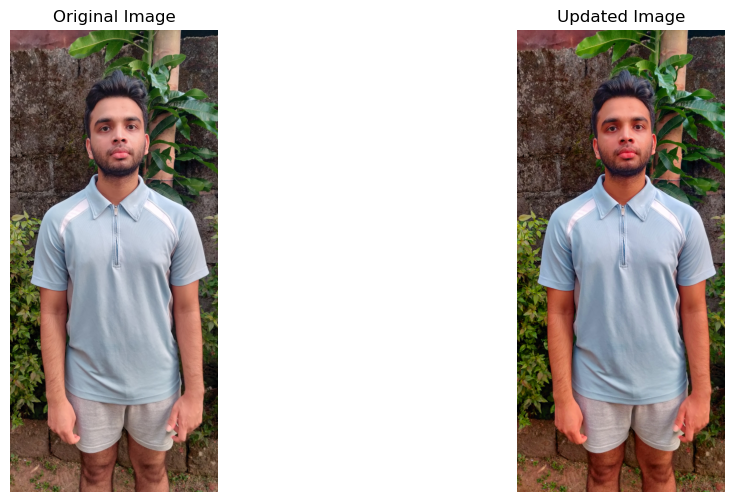

In [21]:
# Display the original and updated images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Updated Image')
plt.axis('off')
plt.show()